### Курс-интенсив [Машинное обучение](http://plyus.pw/ml2020), автор курса - Павел Плюснин
Основа практики позаимствована у [Скрынника Алексея](https://www.hse.ru/staff/ask)

Будем пользоваться стандартными средами, реализованными в библиотеке OpenAI Gym (https://gym.openai.com).

D:\conda1\lib\site-packages\pyglet\image\codecs\wic.py:434: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


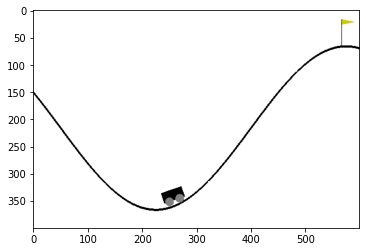

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
# создаем окружение
env = gym.make("MountainCar-v0")
a = env.reset()
# рисуем картинку
#env.render('rgb_array')
plt.imshow(env.render(mode='rgb_array'))
env.close()

### Интерфейс среды в OpenAI gym

Основные методы класса Env:
\begin{itemize}
    \item reset() - инициализация окружения, возвращает первое наблюдение
    \item render() - визуализация текущего состояния среды
    \item step($a$) - выполнить в среде действие a и получить: new observation - новое наблюдение после выполнения действия $a$; reward - вознаграждение за выполненное действие $a$; $is\_done$ - True, если процесс завершился, False иначе; $info$ - дополнительная информация
\end{itemize}

In [3]:
obs0 = env.reset() # начальное состояние - x,y - коорд-ы каретки
print("изначальное состояние среды:", obs0)
# выполняем действие 2 
new_obs, reward, is_done, _ = env.step(2)
print("новое состояние:", new_obs, 
      "вознаграждение", reward)

изначальное состояние среды: [-0.44625768  0.        ]
новое состояние: [-4.4583255e-01  4.2513231e-04] вознаграждение -1.0


In [7]:
def act(s): # s - массив координат
    actions = {'left': 0, 'stop': 1, 'right': 2}
    # в зависимости от полученного состояния среды 
    # выбираем действия так, чтобы тележка достигла флага
    #action = actions['right']
    action = actions['left'] if s[1] < 0 else actions["right"]
    return action

# создаем окружение, с ограничением на число шагов в 249 (wrappers.TimeLimit)
env = gym.wrappers.TimeLimit(
    gym.make("MountainCar-v0").unwrapped, # передаем сюда среду
    max_episode_steps=250)
# проводим инициализацию и запоминаем начальное состояние
s = env.reset() 
done = False
while not done:
    # выполняем действие, получаем s, r, done
    s, r, done, _ = env.step(act(s)) # делаем щаг по стратегии
    # визуализируем окружение
    env.render()

env.close()
if s[0] > 0.47:
    print("Успех!")
else:
    raise NotImplementedError("""
    Исправьте функцию выбора действия!""")

Успех!


## Q-обучение

Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение. Агент, который принимает решения на основе $Q$-функции, не требует модель для обучения и выбора действий, т.е. такой агент также свободен от модели (model-free), как и TD-агент. Уравнение Беллмана для значения Q-функции в равновесии записывается как:

$$Q(s,a)=r(s)+\gamma\sum_s'T(s,a,s')\max_{a'}Q(a',s')$$

Уравнение для итерационного обновления значений Q-функции выглядит следующим образом:
$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

Оформим этот алгоритм в виде класса QLearningAgent:

In [8]:
import random, math

import numpy as np
from collections import defaultdict


class QLearningAgent():
    """
    Q-Learning агент

    Замечание: избегайте прямое использование 
    self._q_values, для этого определены 
    функции: get_q_value, set_q_value
    """

    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        
        self.get_legal_actions = get_legal_actions # действия, которые можно делать 
        self._q_values = \
            defaultdict(lambda: defaultdict(lambda: 0))   # матрица Q - словарь
        # defaultdict - когда запрашиваем объект, которого нет - он возвращает 
        # стандартное значение. В данном случае это еще один словарь из нуля 
        self.alpha = alpha #
        self.epsilon = epsilon # 
        self.discount = discount # штраф за действие (гамма)
        

    def get_q_value(self, state, action):
        return self._q_values[state][action]
    

    def set_q_value(self, state, action, value):
        self._q_values[state][action] = value

Добавим нашему агенту возможность вычислять оценки $V$:

In [9]:
def get_value(self, state):
    """
      Возвращает значение функции полезности, 
      рассчитанной по Q[state, action], 
    """
    possible_actions = self.get_legal_actions(state)
    value = max([self.get_q_value(state, action) for action in possible_actions])
    # Максимальное Q_value для всех возможных действий, которое можно совершить
    return value

QLearningAgent.get_value = get_value

Стратегия нашего агента будет заключаться в выборе лучшего действия, в соответствии с оценками $Q$:

In [10]:
def get_policy(self, state):
    """
      Выбирает лучшее действие, согласно стратегии.
    """
    possible_actions = self.get_legal_actions(state)
    
    # выбираем лучшее действие, согласно стратегии
    best_action = None
    for action in possible_actions:
        if best_action is None:
            best_action = action
        elif self.get_q_value(state, action) > self.get_q_value(state, best_action):
            best_action = action
       
    return best_action

QLearningAgent.get_policy = get_policy

Для конкретной ситуации мы будем выбирать действие, используя $\epsilon$-жадный подход:

In [11]:
def get_action(self, state): # epsilon - greedy stategy 
    """
      Выбирает действие, предпринимаемое в данном 
      состоянии, включая исследование (eps greedy)
      С вероятностью self.epsilon берем случайное 
      действие, иначе действие согласно стратегии 
      (self.get_policy)
    """
    possible_actions = self.get_legal_actions(state)

    # выбираем действие, используя eps-greedy подход
    if np.random.random() < self.epsilon:
        action = np.random.choice(possible_actions, 1)[0]
    else:
        action = self.get_policy(state)
        
    return action

QLearningAgent.get_action = get_action

In [12]:
def update(self, state, action, next_state, reward):
    """
      функция Q-обновления 
    """
    # выполняем Q-обновление, 
    # используем методы getQValue и setQValue
    t = self.alpha*(reward + self.discount*self.get_value(next_state) - self.get_q_value(state, action))
    reference_qvalue = self.get_q_value(state, action) + t
    self.set_q_value(state, action, reference_qvalue)
    
QLearningAgent.update = update

Тестируем нашего агента на задаче Taxi

In [14]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [15]:
def play_and_train(env, agent, t_max=10**4):
    """функция запускает полную игру,
    используя стратегию агента (agent.get_action(s))
    выполняет обновление агента (agent.update(...))
    и возвращает общее вознаграждение
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # выбираем действие
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        
        # выполняем обновление стратегии
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

eps = 0.1 mean reward = 4.2
alpha= 0.5


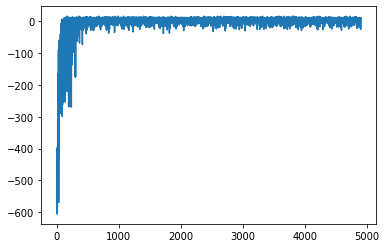

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

agent = QLearningAgent(alpha=0.5, epsilon=0.1,
                       discount=0.9,
                       get_legal_actions=lambda s: range(
                           n_actions))

assert 'get_policy' in dir(agent)
rewards = []
for i in range(5000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon,
              'mean reward =', np.mean(rewards[-10:]))
        print("alpha=", agent.alpha)
        plt.plot(rewards)
        plt.show()

In [19]:
total_reward = 0.0
s = env.reset()
    
for t in range(1000):
    # выбираем действие
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
        
    s = next_s
    total_reward +=r
    if done:
         break
    
    env.render()
total_reward

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|

9.0

## Deep Q-Network

Схема обучения алгоритма DQN изображена на рисунке: 
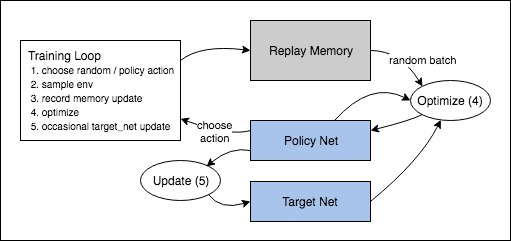

Ключевыми отличиями от обычной аппроксимации нейронной сетью являются два новых элемента: replay buffer и target network.

#### 1. Replay buffer
Хранит информацию, которую получал агент во время взаимодействия со средой. Позволяет случайно сэмплировать эту информацию в виде кортежей: $<S_{t-1}, a_{t-1}, r_{t-1}, s_{t}, {done}>$.

#### 2. Target Network $Q_{\theta}^{target}$
Используется для вычисления loss функции Policy Net. 
$$L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{\theta}^{target}(s', a')]) ^2.$$
Каждые $N$ шагов обновляется весами $Q_{\theta}$.

#### 3. Policy Net $Q_{\theta}$
Используется для взаимодействия с окружением. Обучается используя накопленный в Replay Buffer опыт.


In [20]:
# импортируем необходимые библиотеки

import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# если видеокарта доступна, то будем ее использовать
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [13]:
# определяем класс Q-Network

class QNetwork(nn.Module):
    def __init__(self):
        """
        определение сети
        """
        super().__init__()
        
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        """
        определение графа вычислений
        :param x: вход
        :return: 
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def sample_action(self, obs, epsilon):
        """
        сэмплирование действия
        :param obs: 
        :param epsilon: 
        :return: 
        """
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 1)
        else:
            return out.argmax().item()

### Реализуйте методы класса ReplayBuffer

In [14]:
class ReplayBuffer():

    def __init__(self, max_size):
        """
        создаем структуру для хранения данных
        """
        #~~~~~~~~ Ваш код здесь ~~~~~~~~~~~        
        raise NotImplementedError        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        

    def put(self, transition):
        """
        помещаем данные в replay buffer
        :param transition: (s, a, r, next_s, done_mask)
        :return:
        """
        #~~~~~~~~ Ваш код здесь ~~~~~~~~~~~        
        raise NotImplementedError        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        

    def sample(self, n):
        """
        сэмплируем батч заданного размера
        :param n: размер мини-батча
        :return:
        """
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        # сэмплируем случайный батч и заполняем s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst
        #~~~~~~~~ Ваш код здесь ~~~~~~~~~~~        
        raise NotImplementedError        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def __len__(self):
        """
        возвращает размер replay buffer'а
        :return: len(replay_buffer)
        """
        #~~~~~~~~ Ваш код здесь ~~~~~~~~~~~        
        raise NotImplementedError        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [16]:
def train(q, q_target, replay_buffer, optimizer, batch_size, gamma, updates_number=10):
    """
    тренируем нашу архитектуру
    :param q: policy сеть
    :param q_target: target сеть
    :param replay_buffer:
    :param optimizer:
    :param batch_size: размер мини-батча
    :param gamma: дисконтирующий множитель
    :param updates_number: количество обновлений, которые необходимо выполнить
    :return:
    """
    for i in range(updates_number):
        # сэмплируем мини-батч из replay buffer'а
        s, a, r, s_prime, done_mask = replay_buffer.sample(batch_size)

        # получаем полезность, для выбранного действия q сети
        q_out = q(s)
        q_a = q_out.gather(1, a)

        # получаем значение max_q target сети и считаем значение target
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask

        # определяем loss функцию, для q!
        loss = F.smooth_l1_loss(q_a, target.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [17]:
def run(learning_rate, gamma, buffer_max_size, batch_size, target_update_interval,
        replay_buffer_start_size, print_interval=20, n_episodes=2000):
    # создаем окружение
    env = gym.make('CartPole-v1')

    # создаем q и target_q
    q = QNetwork()
    q_target = QNetwork()

    # копируем веса q в target_q
    q_target.load_state_dict(q.state_dict())

    # создаем replay buffer
    replay_buffer = ReplayBuffer(max_size=buffer_max_size)

    score = 0.0

    # инициализируем оптимизатор, полученным lr
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(n_episodes):

        # постепенно изменяем eps с 8% до 1%
        epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))

        s = env.reset()

        # выполянем 600 шагов в окружении и сохраняем, полученные данные
        for t in range(600):

            # получаем действие, используя сеть q
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)

            # выполняем действие в окружении
            s_prime, r, done, info = env.step(a)

            # добавляем данные в replay buffer
            done_mask = 0.0 if done else 1.0
            
            # сжимаем вознаграждения и добавляем в replay buffer
            replay_buffer.put((s, a, r / 100.0, s_prime, done_mask))

            s = s_prime

            score += r

            if done:
                break

        if len(replay_buffer) > replay_buffer_start_size:
            train(q, q_target, replay_buffer, optimizer, batch_size, gamma)

        if n_epi % target_update_interval == 0 and n_epi != 0:
            q_target.load_state_dict(q.state_dict())

        if n_epi % print_interval == 0 and n_epi != 0:
            print("# of episode :{}, avg score : {:.1f}, buffer size : {}, epsilon : {:.1f}%".format(
                n_epi, score / print_interval, len(replay_buffer), epsilon * 100))
            score = 0.0
    env.close()

In [1]:
# определяем гиперпараметры
run(learning_rate=0.0005,
    gamma=0.98,
    buffer_max_size=50000,
    batch_size=32,
    target_update_interval=10,
    replay_buffer_start_size=2000)

NameError: name 'run' is not defined